In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance, ImageColor, ImageOps, ImageDraw

In [2]:
ITEM_SIZE = (20, 20)

# Combining with atlas

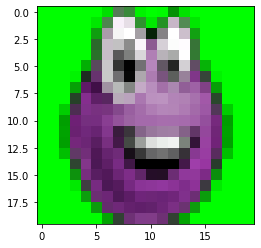

In [3]:
im_player = Image.open("Lazarus_stand.gif").convert("RGB")
im_player = im_player.crop((0,2,38,40))
im_player = im_player.resize(ITEM_SIZE)
plt.imshow(im_player)

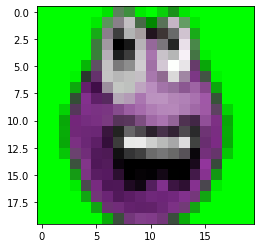

In [4]:
im_player_sq = Image.open("Lazarus_squished.gif").convert("RGB")
im_player_sq = im_player_sq.crop((0,2,38,40))
im_player_sq = im_player_sq.resize(ITEM_SIZE)
plt.imshow(im_player_sq)

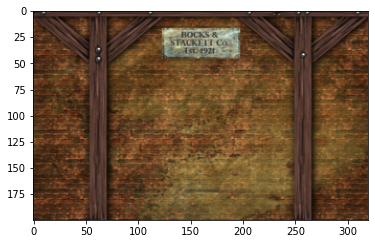

In [24]:
# background

im_bg = Image.open("Background.bmp").convert("RGB")
im_bg = im_bg.resize((320, 200))
plt.imshow(im_bg)

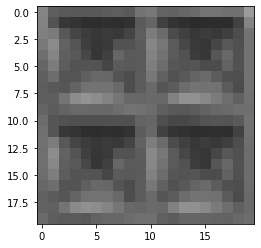

In [5]:
im_wall = Image.open("Wall.gif").convert("RGB")
im_wall = im_wall.crop((1,1,39,39))
im_wall = im_wall.resize(ITEM_SIZE)
plt.imshow(im_wall)

In [6]:
def get_box(file_name: str):
    im = Image.open(file_name).convert("RGB")
    im = im.crop((1,1,39,39))
    im = im.resize(ITEM_SIZE)        
    return im
im_stone = get_box("StoneBox.gif")
im_wood = get_box("WoodBox.gif")
im_rock = get_box("Rock.gif")
im_metal = get_box("MetalBox.gif")
im_card = get_box("CardBox.gif")
im_btn = get_box("Button.gif")

im_arr = [im_player, im_player_sq, im_wall, im_stone, im_wood, im_rock, im_metal, im_card, im_btn]

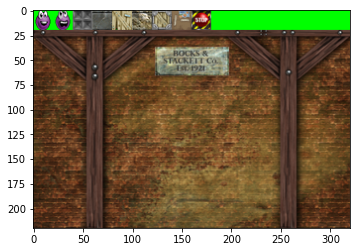

In [26]:
im_atlas = Image.new('RGB', (max(20*len(im_arr), 320), 20+200), (0x00, 0xFF, 0x00))
for idx, im in enumerate(im_arr):
    im_atlas.paste(im, (20*idx, 0))
im_atlas.paste(im_bg, (0, 20))
    
plt.imshow(im_atlas)

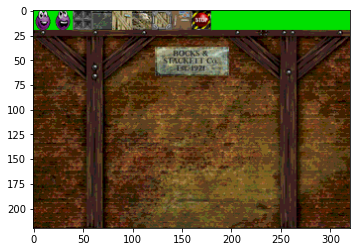

In [27]:
im_atlas = ImageOps.posterize(im_atlas, 3)

plt.imshow(im_atlas)

In [28]:
palette_raw = np.array([], dtype="int32")
atlas_bin = np.zeros(im_atlas.size[0]*im_atlas.size[1], dtype="int8")

def tohex(color_tuple):
    scale = lambda n: int(n*(63/255))
    return (scale(color_tuple[0])<<16) + (scale(color_tuple[1])<<8) + scale(color_tuple[2])

for y in range(im_atlas.size[1]):
    for x in range(im_atlas.size[0]):
        color = tohex(im_atlas.getpixel((x,y)))
        found = np.where(palette_raw == color)[0]
        if len(found) != 0:
            atlas_bin[y*im_atlas.size[0] + x] = found[0]
        else:
            palette_raw = np.append(palette_raw, color)
            atlas_bin[y*im_atlas.size[0] + x] = len(palette_raw)-1
            
palette_raw, atlas_bin

(array([  14080,   12032,  988943,  466695,    7936,  990991, 2039583,
         986895, 1513239, 2039575, 2565927, 2041631, 1515287, 1513223,
        2563863, 2565911, 2039567, 1511175, 2565919, 2037519, 1513231,
         986887,  460551, 3618615, 3616567, 3090223,  988951,  462599,
        3090207, 2037527, 1511183, 1515303, 1515295, 1513255,       0,
         460544,  986880, 2563879,    1792,    9984, 2037535, 2563871,
         458752, 3092271,  988959, 1513247, 2041639, 3086095, 2563855,
        1513216,  983040, 1509120,  464647, 2035487, 2041647,  984839,
        3092224, 3618560, 1515264, 2031616, 2555904, 3080192, 3081984,
        1511168, 2561831, 3616559, 3618607, 3088151, 2039591, 2563840,
        1507328, 3606279, 3608335, 3081991, 2565888, 1511191, 1509143,
        2567983, 2043695, 3088143, 2039552, 3610391, 3612447, 2037504,
           1799, 2033439, 1509151, 3092263, 3616551, 3090199, 3614503,
         983063,  983055, 2037543, 1507351, 2567975, 2565935, 2033415,
      

## Sanity check by reconstruction

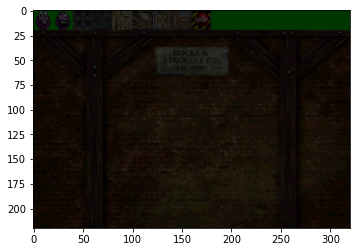

In [29]:
im_atlas_recon = Image.new('RGB', im_atlas.size, (0x00, 0xFF, 0x00))
num_to_hex = lambda x: ((x>>16)&0xFF, (x>>8)&0xFF, x&0xFF)
for y in range(im_atlas.size[1]):
    for x in range(im_atlas.size[0]):
        im_atlas_recon.putpixel((x, y), num_to_hex(palette_raw[atlas_bin[y*im_atlas.size[0]+x]]))

plt.imshow(im_atlas_recon)

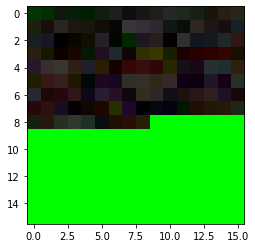

In [30]:
im_palette = Image.new('RGB', (16, 16), (0x00, 0xFF, 0x00))
for y in range(16):
    for x in range(16):
        if y*16+x < len(palette_raw):
            im_palette.putpixel((x, y), num_to_hex(palette_raw[y*16+x]))

plt.imshow(im_palette)

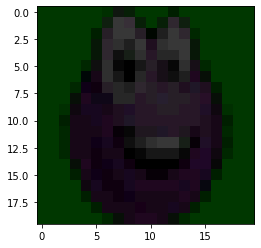

In [31]:
im_player_recon = Image.new('RGB', ITEM_SIZE, (0x00, 0xFF, 0x00))
for y in range(20):
    for x in range(20):
        im_player_recon.putpixel((x, y), num_to_hex(palette_raw[atlas_bin[y*im_atlas.size[0]+x]]))
plt.imshow(im_player_recon)

## Write to files

In [32]:
import struct
 
def write_rest(idx, height, file_name, payload):
    with open(file_name, "w+b") as f:
        for y in range(height):
            pay = payload[y*im_atlas.size[0] + idx*20:y*im_atlas.size[0] + idx*20 + 20]
            #pay = bytearray([struct.unpack("<B", struct.pack(">B", i))[0] for i in pay])
            print(f"Writing {pay} to {file_name}")
            f.write(pay)

In [33]:
# palette
with open("palet.b", "w+b") as f:
    for color in palette_raw:
        payload = struct.pack("I", color)
        f.write(payload)

In [34]:
names = ["player.b", "playsq.b", "wall.b", "stone.b", "wood.b", "rock.b", "metal.b", "card.b", "btn.b"]

byte_arr = atlas_bin.tobytes()
for idx, name in enumerate(names):
    write_rest(idx, 20, name, byte_arr)

Writing b'\x00\x00\x00\x00\x00\x00\x01\x02\x03\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00' to player.b
Writing b'\x00\x00\x00\x00\x00\x00\x05\x17\x18\x03\x00\x03\x19\x05\x00\x00\x00\x00\x00\x00' to player.b
Writing b"\x00\x00\x00\x00\x00\x04%\x17\x17%&\x06\x17\x19'\x00\x00\x00\x00\x00" to player.b
Writing b'\x00\x00\x00\x00\x004\x19+\x06\x175+\x17\x174\x00\x00\x00\x00\x00' to player.b
Writing b'\x00\x00\x00\x00\x004\x19\x07\x0c+@\n\n\x174\x00\x00\x00\x00\x00' to player.b
Writing b'\x00\x00\x00\x00\'\x07+\x16"\x08%K\x16+K\'\x00\x00\x00\x00' to player.b
Writing b'\x00\x00\x00\x00TL+\x08"\n@K\x07\x06U\x1b\x00\x00\x00\x00' to player.b
Writing b"\x00\x00\x00'[\\%\n\x06\x19%@%5]5\x04\x00\x00\x00" to player.b
Writing b'\x00\x00\x00\x1bUdd\n\n@%e%%@f\x1b\x00\x00\x00' to player.b
Writing b'\x00\x00\x01gVVL5n@@%%@@ng\x01\x00\x00' to player.b
Writing b'\x00\x00\x04LLVU5]@@@@@@5L\x04\x00\x00' to player.b
Writing b"\x00\x00'LLLUs\x16((]@(L5L'\x00\x00" to player.b
Writing b"\x00\x00'LL[V\\\x07\x06+

In [37]:
# write bg

with open("bg.b", "w+b") as f:
    for y in range(20, 220):
        payload = byte_arr[y*im_atlas.size[0]:y*im_atlas.size[0] + 320]
        f.write(payload)

## Writing test palettes

In [16]:
# Red
with open("paletr.b", "w+b") as f:
    for color in palette_raw:
        payload = struct.pack("I", 0xFF<<16)
        f.write(payload)
# green
with open("paletg.b", "w+b") as f:
    for color in palette_raw:
        payload = struct.pack("I", 0xFF<<8)
        f.write(payload)
# blue
with open("paletb.b", "w+b") as f:
    for color in palette_raw:
        payload = struct.pack("I", 0xFF)
        f.write(payload)

In [17]:
# test sprite
with open("testsp.b", "w+b") as f:
    for color in range(20*20):
        payload = struct.pack("B", 0xFF)
        f.write(payload)